In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("Dark2")

results = pd.read_parquet("./sampling_scaling_rtt.gzip")

# only look at the empirical-high timing model (ground truth)
results = results[results["timing_model"] == "empirical-high"].copy()
results["timing_model"] = results["timing_model"].cat.remove_unused_categories()
results["sampling_scheme"] = results["sampling_scheme"].astype(
    pd.CategoricalDtype(
        ['greedy',
         'ideal',
         'adaptive-empirical',
         'adaptive-theoretical-exgaussian',
         'adaptive-theoretical-rayleigh',
         'adaptive-fitted-naive-exgaussian',
         'adaptive-fitted-naive-rayleigh',
         'adaptive-power-empirical',
         'adaptive-power-theoretical-exgaussian',
         'adaptive-power-theoretical-rayleigh',
         'adaptive-power-fitted-naive-exgaussian',
         'adaptive-power-fitted-naive-rayleigh',
         'periodic-1.0s',
         'periodic-3.0s',
         'periodic-5.0s',
         'hold-1.0s',
         'hold-3.0s',
         'hold-5.0s'], ordered=True
        )
)

def _classify_sampling(s: str) -> str:
    ssplit = s.split("-")
    if len(ssplit) > 1:
        if ssplit[0] == "adaptive":
            if ssplit[1] == "power":
                return "adaptive-energy"
            else:
                return "adaptive-ttf"
        return ssplit[0]
    else:
        return "reference"

results["sampling_class"] = (
    results["sampling_scheme"]
    .apply(_classify_sampling)
    .astype(pd.CategoricalDtype(["adaptive-energy", "adaptive-ttf", "reference", "periodic", "hold"]))
)

# remove the realistic-low, high adaptive schemes
# results = results[~results["sampling_scheme"].str.endswith("low") & ~results["sampling_scheme"].str.endswith("high")]
results["sampling_scheme"] = results["sampling_scheme"].cat.remove_unused_categories()

results

,rtt,step,previous_ttf,execution_time,step_duration,ttf,wait_time,samples,cumulative_duration,cumulative_samples,repetition,energy,cumulative_energy,timing_model,sampling_scheme,sampling_class
0,1.5,1,1.500000,4.024925,6.387686,2.362761,0.862761,1,6.387686,1,35,0.131815,0.131815,empirical-high,adaptive-empirical,adaptive-ttf
1,1.5,2,2.362761,12.475631,15.791679,3.316048,1.816048,5,22.179365,6,35,0.416875,0.548690,empirical-high,adaptive-empirical,adaptive-ttf
2,1.5,3,3.316048,4.683471,8.678263,3.994793,2.494793,2,30.857629,8,35,0.202174,0.750864,empirical-high,adaptive-empirical,adaptive-ttf
3,1.5,4,3.994793,6.658278,8.482648,1.824370,0.324370,2,39.340277,10,35,0.199240,0.950104,empirical-high,adaptive-empirical,adaptive-ttf
4,1.5,5,1.824370,4.414917,8.186260,3.771343,2.271343,2,47.526537,12,35,0.194794,1.144898,empirical-high,adaptive-empirical,adaptive-ttf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295995,4.0,116,5.754190,5.485901,14.000000,8.514099,4.514099,2,1594.000000,226,42,0.432000,48.996000,empirical-high,periodic-5.0s,periodic
1295996,4.0,117,8.514099,6.491751,14.000000,7.508249,3.508249,2,1608.000000,228,42,0.432000,49.428000,empirical-high,periodic-5.0s,periodic
1295997,4.0,118,7.508249,5.281174,14.000000,8.718826,4.718826,2,1622.000000,230,42,0.432000,49.860000,empirical-high,periodic-5.0s,periodic
1295998,4.0,119,8.718826,8.862974,14.000000,5.137026,1.137026,2,1636.000000,232,42,0.432000,50.292000,empirical-high,periodic-5.0s,periodic


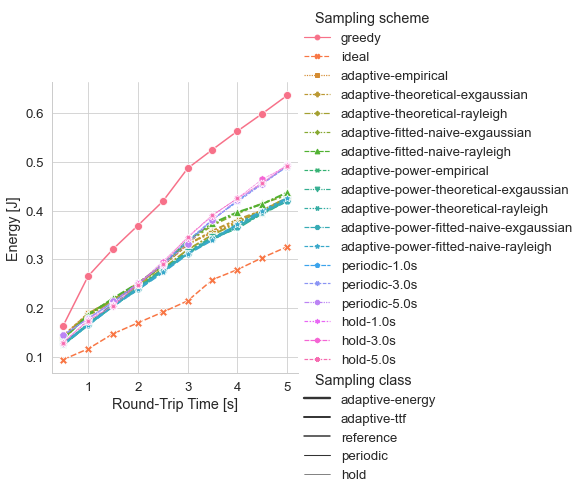

In [2]:
fg = sns.relplot(
    kind="line",
    errorbar=None,
    data=results.rename(columns={"sampling_scheme": "Sampling scheme", "sampling_class": "Sampling class"}),
    x="rtt",
    y="energy",
    hue="Sampling scheme",
    style="Sampling scheme",
    size="Sampling class",
    markers=True,
    aspect=1,
    markersize=8,
)
fg.set_axis_labels("Round-Trip Time [s]", "Energy [J]")
# fg.legend.set_title("Sampling Scheme")
plt.show()

In [3]:
energy_at_max_rtt = (
    results[results["rtt"] == results["rtt"].max()]
    .groupby("sampling_scheme")
    ["energy"]
    .mean()
    .sort_values()
)
energy_at_max_rtt

sampling_scheme
ideal                                     0.325581
adaptive-power-theoretical-exgaussian     0.419432
adaptive-power-fitted-naive-exgaussian    0.420111
adaptive-power-empirical                  0.420749
adaptive-power-theoretical-rayleigh       0.421716
adaptive-empirical                        0.422570
adaptive-power-fitted-naive-rayleigh      0.425001
adaptive-theoretical-exgaussian           0.425516
adaptive-theoretical-rayleigh             0.426076
adaptive-fitted-naive-exgaussian          0.431741
adaptive-fitted-naive-rayleigh            0.436988
periodic-3.0s                             0.490230
periodic-1.0s                             0.490320
hold-3.0s                                 0.491760
hold-5.0s                                 0.492330
periodic-5.0s                             0.493290
hold-1.0s                                 0.494880
greedy                                    0.636330
Name: energy, dtype: float64

/Users/molguin/.venvs/EdgeDroid/lib/python3.10/site-packages/seaborn/categorical.py:1727: UserWarning: You passed a edgecolor/edgecolors ((0.10588235294117647, 0.6196078431372549, 0.4666666666666667)) for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/molguin/.venvs/EdgeDroid/lib/python3.10/site-packages/seaborn/categorical.py:1727: UserWarning: You passed a edgecolor/edgecolors ((0.8509803921568627, 0.37254901960784315, 0.00784313725490196)) for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/molguin/.venvs/EdgeDroid/lib/python3.10/site-packages/seaborn/categorical.py:1727: UserWarning: You passed a edgecolor/edgecolors ((0.4588235294117647, 0.4392156862745098, 0.7019607843137254)) for an unfilled marker ('+').  Matplotlib is ignoring

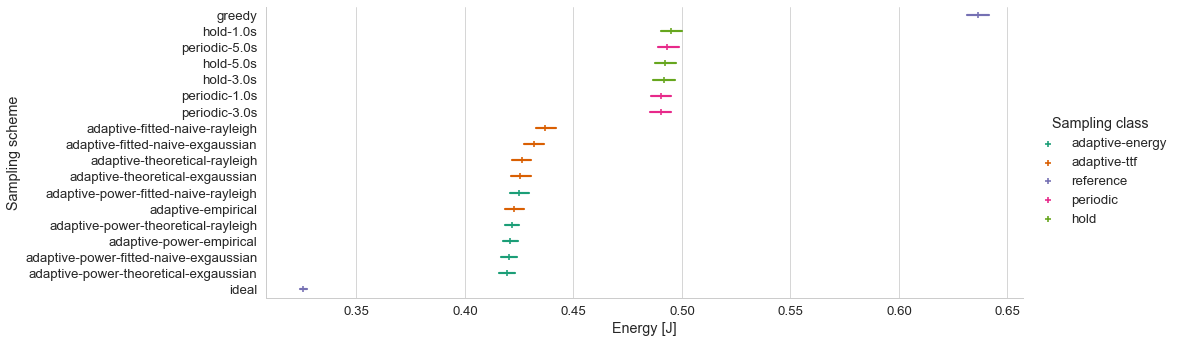

In [4]:
fg = sns.catplot(
    kind="point",
    errorbar=("ci", 95),
    data=results[results["rtt"] == results["rtt"].max()],
    y="sampling_scheme",
    order=reversed(energy_at_max_rtt.index),
    x="energy",
    join=False,
    hue="sampling_class",
    # hue_order=["adaptive-energy", "adaptive-ttf", "periodic", "hold", "reference"],
    aspect=3,
    markers="+",
)
# for ax in fg.axes.flat:
#     ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=55, ha="right", rotation_mode="anchor")

fg.set_axis_labels("Energy [J]", "Sampling scheme")
fg.legend.set_title("Sampling class")
# fg.set(xscale="log", xlim=(0.1, 10))
plt.show()

In [5]:
import numpy as np

energies_maxrtt = results.loc[(results["rtt"] == results["rtt"].max())].groupby(["sampling_class", "sampling_scheme"])["energy"].describe(percentiles=[])
energies_maxrtt["var"] = np.square(energies_maxrtt["std"])
energies_maxrtt

count      mean  \
sampling_class  sampling_scheme                                            
adaptive-energy adaptive-power-empirical                7200.0  0.420749   
                adaptive-power-theoretical-exgaussian   7200.0  0.419432   
                adaptive-power-theoretical-rayleigh     7200.0  0.421716   
                adaptive-power-fitted-naive-exgaussian  7200.0  0.420111   
                adaptive-power-fitted-naive-rayleigh    7200.0  0.425001   
adaptive-ttf    adaptive-empirical                      7200.0  0.422570   
                adaptive-theoretical-exgaussian         7200.0  0.425516   
                adaptive-theoretical-rayleigh           7200.0  0.426076   
                adaptive-fitted-naive-exgaussian        7200.0  0.431741   
                adaptive-fitted-naive-rayleigh          7200.0  0.436988   
reference       greedy                                  7200.0  0.636330   
                ideal                                   7200.0  0.325581   
periodic        periodic-1.0s                           7200.0  0.490320   
                periodic-3.0s                           7200.0  0.490230   
                periodic-5.0s                           7200.0  0.493290   
hold            hold-1.0s                               7200.0  0.494880   
                hold-3.0s                               7200.0  0.491760   
                hold-5.0s                               7200.0  0.492330   

                                                             std       min  \
sampling_class  sampling_scheme                                              
adaptive-energy adaptive-power-empirical                0.154344  0.365385   
                adaptive-power-theoretical-exgaussian   0.154254  0.365384   
                adaptive-power-theoretical-rayleigh     0.150188  0.374137   
                adaptive-power-fitted-naive-exgaussian  0.165071  0.361866   
                adaptive-power-fitted-naive-rayleigh    0.187110  0.361866   
adaptive-ttf    adaptive-empirical                      0.187103  0.306255   
                adaptive-theoretical-exgaussian         0.190461  0.305649   
                adaptive-theoretical-rayleigh           0.196078  0.310605   
                adaptive-fitted-naive-exgaussian        0.198860  0.297218   
                adaptive-fitted-naive-rayleigh          0.200770  0.300101   
reference       greedy                                  0.214086  0.432000   
                ideal                                   0.070110  0.216005   
periodic        periodic-1.0s                           0.211667  0.291000   
                periodic-3.0s                           0.210447  0.291000   
                periodic-5.0s                           0.219261  0.291000   
hold            hold-1.0s                               0.215434  0.291000   
                hold-3.0s                               0.214331  0.291000   
                hold-5.0s                               0.212625  0.291000   

                                                             50%       max  \
sampling_class  sampling_scheme                                              
adaptive-energy adaptive-power-empirical                0.376275  2.120053   
                adaptive-power-theoretical-exgaussian   0.376276  2.538133   
                adaptive-power-theoretical-rayleigh     0.382532  1.914378   
                adaptive-power-fitted-naive-exgaussian  0.361866  2.100548   
                adaptive-power-fitted-naive-rayleigh    0.361866  2.532548   
adaptive-ttf    adaptive-empirical                      0.338821  1.639211   
                adaptive-theoretical-exgaussian         0.338821  2.059494   
                adaptive-theoretical-rayleigh           0.343615  2.496050   
                adaptive-fitted-naive-exgaussian        0.327779  1.627774   
                adaptive-fitted-naive-rayleigh          0.327779  2.491774   
reference       greedy                 

In [6]:
import scipy.stats as stats
ix = pd.IndexSlice

# calculate the 95% CI for the difference between the means wrt to the ideal case
ideal_mean = energies_maxrtt.loc[ix["reference", "ideal"], "mean"]
ideal_var = energies_maxrtt.loc[ix["reference", "ideal"], "var"]
sample_size = results[(results["rtt"] == results["rtt"].max())].groupby("sampling_scheme").size().unique().take(0)

mean_diff = energies_maxrtt["mean"] - ideal_mean
t_critical = stats.t.ppf(q=0.95, df=sample_size + sample_size - 2)
spooled_variance = (((sample_size - 1) * np.square(energies_maxrtt["var"])) + ((sample_size - 1) * np.square(ideal_var))) / (sample_size + sample_size - 2)

t_factor = t_critical * np.sqrt(2 * np.square(spooled_variance) / sample_size)

energies_maxrtt["mean_diff_ideal"] = mean_diff
energies_maxrtt["mean_diff_ideal_95ci"] = t_factor

energies_maxrtt["mean_diff_ideal_percent"] = mean_diff / ideal_mean
energies_maxrtt["mean_diff_ideal_95ci_percent"] = t_factor / ideal_mean
energies_maxrtt

count      mean  \
sampling_class  sampling_scheme                                            
adaptive-energy adaptive-power-empirical                7200.0  0.420749   
                adaptive-power-theoretical-exgaussian   7200.0  0.419432   
                adaptive-power-theoretical-rayleigh     7200.0  0.421716   
                adaptive-power-fitted-naive-exgaussian  7200.0  0.420111   
                adaptive-power-fitted-naive-rayleigh    7200.0  0.425001   
adaptive-ttf    adaptive-empirical                      7200.0  0.422570   
                adaptive-theoretical-exgaussian         7200.0  0.425516   
                adaptive-theoretical-rayleigh           7200.0  0.426076   
                adaptive-fitted-naive-exgaussian        7200.0  0.431741   
                adaptive-fitted-naive-rayleigh          7200.0  0.436988   
reference       greedy                                  7200.0  0.636330   
                ideal                                   7200.0  0.325581   
periodic        periodic-1.0s                           7200.0  0.490320   
                periodic-3.0s                           7200.0  0.490230   
                periodic-5.0s                           7200.0  0.493290   
hold            hold-1.0s                               7200.0  0.494880   
                hold-3.0s                               7200.0  0.491760   
                hold-5.0s                               7200.0  0.492330   

                                                             std       min  \
sampling_class  sampling_scheme                                              
adaptive-energy adaptive-power-empirical                0.154344  0.365385   
                adaptive-power-theoretical-exgaussian   0.154254  0.365384   
                adaptive-power-theoretical-rayleigh     0.150188  0.374137   
                adaptive-power-fitted-naive-exgaussian  0.165071  0.361866   
                adaptive-power-fitted-naive-rayleigh    0.187110  0.361866   
adaptive-ttf    adaptive-empirical                      0.187103  0.306255   
                adaptive-theoretical-exgaussian         0.190461  0.305649   
                adaptive-theoretical-rayleigh           0.196078  0.310605   
                adaptive-fitted-naive-exgaussian        0.198860  0.297218   
                adaptive-fitted-naive-rayleigh          0.200770  0.300101   
reference       greedy                                  0.214086  0.432000   
                ideal                                   0.070110  0.216005   
periodic        periodic-1.0s                           0.211667  0.291000   
                periodic-3.0s                           0.210447  0.291000   
                periodic-5.0s                           0.219261  0.291000   
hold            hold-1.0s                               0.215434  0.291000   
                hold-3.0s                               0.214331  0.291000   
                hold-5.0s                               0.212625  0.291000   

                                                             50%       max  \
sampling_class  sampling_scheme                                              
adaptive-energy adaptive-power-empirical                0.376275  2.120053   
                adaptive-power-theoretical-exgaussian   0.376276  2.538133   
                adaptive-power-theoretical-rayleigh     0.382532  1.914378   
                adaptive-power-fitted-naive-exgaussian  0.361866  2.100548   
                adaptive-power-fitted-naive-rayleigh    0.361866  2.532548   
adaptive-ttf    adaptive-empirical                      0.338821  1.639211   
                adaptive-theoretical-exgaussian         0.338821  2.059494   
                adaptive-theoretical-rayleigh           0.343615  2.496050   
                adaptive-fitted-naive-exgaussian        0.327779  1.627774   
                adaptive-fitted-naive-rayleigh          0.327779  2.491774   
reference       greedy                 

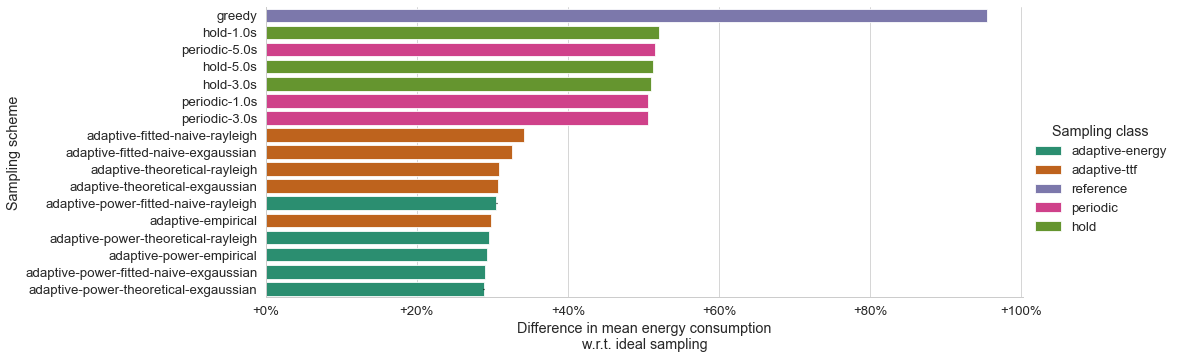

In [7]:
import matplotlib.ticker as tkr

plot_data = energies_maxrtt.reset_index().query("sampling_scheme != 'ideal'")


fg = sns.catplot(
    kind="bar",
    errorbar=None,
    data=plot_data,
    y="sampling_scheme",
    x="mean_diff_ideal_percent",
    aspect=3,
    xerr=plot_data["mean_diff_ideal_95ci_percent"],
    order=plot_data.sort_values("mean_diff_ideal", ascending=False)["sampling_scheme"],
    hue="sampling_class",
    dodge=False,
)
for ax in fg.axes.flat:
    # pass
    # ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=55, ha="right", rotation_mode="anchor")
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f"{y:+0.0%}"))

fg.set_axis_labels("Difference in mean energy consumption\nw.r.t. ideal sampling", "Sampling scheme")
fg.legend.set_title("Sampling class")
plt.show()

In [8]:
best_schemes = plot_data.sort_values("mean_diff_ideal", ascending=False)["sampling_scheme"][-5:]
best_schemes

5                        adaptive-empirical
2       adaptive-power-theoretical-rayleigh
0                  adaptive-power-empirical
3    adaptive-power-fitted-naive-exgaussian
1     adaptive-power-theoretical-exgaussian
Name: sampling_scheme, dtype: category
Categories (18, object): ['greedy' < 'ideal' < 'adaptive-empirical' < 'adaptive-theoretical-exgaussian' ... 'periodic-5.0s' < 'hold-1.0s' < 'hold-3.0s' < 'hold-5.0s']

In [9]:
results_best = results[np.isin(results["sampling_scheme"], best_schemes)].copy()
results_best["sampling_scheme"] = results_best["sampling_scheme"].cat.remove_unused_categories()
results_best

,rtt,step,previous_ttf,execution_time,step_duration,ttf,wait_time,samples,cumulative_duration,cumulative_samples,repetition,energy,cumulative_energy,timing_model,sampling_scheme,sampling_class
0,1.5,1,1.500000,4.024925,6.387686,2.362761,0.862761,1,6.387686,1,35,0.131815,0.131815,empirical-high,adaptive-empirical,adaptive-ttf
1,1.5,2,2.362761,12.475631,15.791679,3.316048,1.816048,5,22.179365,6,35,0.416875,0.548690,empirical-high,adaptive-empirical,adaptive-ttf
2,1.5,3,3.316048,4.683471,8.678263,3.994793,2.494793,2,30.857629,8,35,0.202174,0.750864,empirical-high,adaptive-empirical,adaptive-ttf
3,1.5,4,3.994793,6.658278,8.482648,1.824370,0.324370,2,39.340277,10,35,0.199240,0.950104,empirical-high,adaptive-empirical,adaptive-ttf
4,1.5,5,1.824370,4.414917,8.186260,3.771343,2.271343,2,47.526537,12,35,0.194794,1.144898,empirical-high,adaptive-empirical,adaptive-ttf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575995,4.0,116,11.060040,2.862801,14.251208,11.388407,7.388407,1,1815.352262,146,31,0.324768,43.436284,empirical-high,adaptive-power-theoretical-rayleigh,adaptive-energy
575996,4.0,117,11.388407,7.291518,14.251208,6.959691,2.959691,1,1829.603470,147,31,0.324768,43.761052,empirical-high,adaptive-power-theoretical-rayleigh,adaptive-energy
575997,4.0,118,6.959691,10.185618,14.251208,4.065590,0.065590,1,1843.854679,148,31,0.324768,44.085820,empirical-high,adaptive-power-theoretical-rayleigh,adaptive-energy
575998,4.0,119,4.065590,19.872016,25.323372,5.451356,1.451356,3,1869.178051,151,31,0.712851,44.798671,empirical-high,adaptive-power-theoretical-rayleigh,adaptive-energy


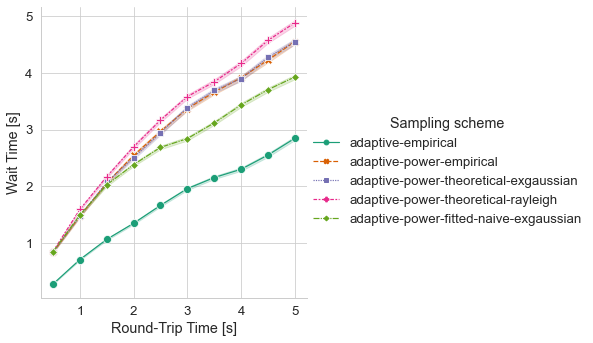

In [10]:
fg = sns.relplot(
    kind="line",
    errorbar=("ci", 95),
    data=results_best,
    x="rtt",
    y="wait_time",
    hue="sampling_scheme",
    style="sampling_scheme",
    markers=True,
    markersize=8,
)
fg.set_axis_labels("Round-Trip Time [s]", "Wait Time [s]")
fg.legend.set_title("Sampling scheme")
plt.show()